In [1]:
import requests
import networkx
import time
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
%matplotlib inline
import scipy.spatial as spt
from collections import Counter, defaultdict
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
def empericalcdf(G):
    N = len(G.nodes())
    cdf = []
    degrees = np.arange(1, np.max(G.degree().values()))
    count = Counter(G.degree().values())
    for deg in degrees:
        probas = np.array([float(count[k]) if k <= deg else 0 for k in count.keys()])
        probas = np.sum(probas)/N
        cdf.append(probas)
    return degrees, cdf

def empericalpdf(G):
    counter = Counter(G.degree().values())
    degrees = counter.keys()
    N = len(G.nodes())
    pdf = np.array([float(val) / N for val in counter.values()])
    return degrees, pdf

In [3]:
def get_friends_ids(uid): 
    friends_url = 'https://api.vk.com/method/friends.get?user_id=uid&v=5.73'
    json_response = requests.get(friends_url.replace('uid',str(uid))).json()
    if json_response.get('error'):
#         print json_response.get('error')
        return list()
    return json_response[u'response']


In [5]:
def print_info_about(id_interest):  
    resp=requests.get('https://api.vk.com/method/users.get?user_ids=uid&v=5.73'.replace('uid',str(id_interest))).json()[u'response']
    print(resp[0][u'first_name'].strip()+' '+resp[0][u'last_name'].strip())

In [ ]:
graph = {}
my_id = 213179289
friends_ids = get_friends_ids(my_id)['items']
for friend_id in friends_ids:
    graph[friend_id] = get_friends_ids(friend_id)['items']
#     print ('Processing id: ', friend_id, len(graph[friend_id]))

In [134]:
friends = nx.Graph()
friends.add_nodes_from(graph.keys())

In [135]:
# соединяем друзей дружащих друг с другом
for friend_id in friends_ids:
    for fof in graph[friend_id]:
        if friend_id != fof and fof in friends_ids:
            friends.add_edge(friend_id, fof)

In [136]:
number = dict()
ind = 0
for node in friends.nodes():
    number[node] = ind
    ind += 1

In [285]:
networkx.write_gml(friends, "adamnet.gml")
G = nx.read_gml('adamnet.gml')
k = G.degree()
degree = Counter(k.values())

We can see at the plot below that graph has some structure: there are 3 groups of nodes.

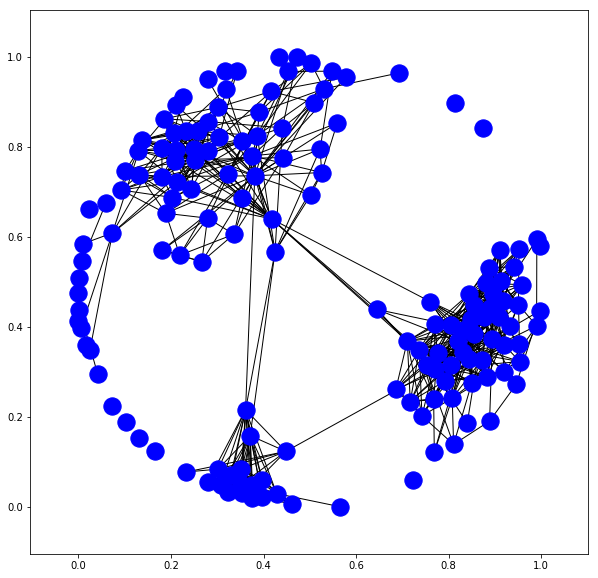

In [814]:
plt.figure(1, figsize=(10,10))
pos = nx.spring_layout(friends)
nx.draw_networkx(friends,pos,with_labels=False,node_color='b',font_size=6)

#### Let's look at the degree probability distribution

In [365]:
degrees, pdf = empericalpdf(friends)

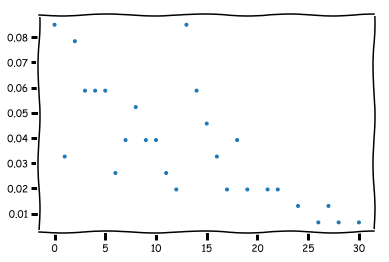

In [1818]:
plt.plot(degrees, pdf,'.')

#### Look at the degree probability distribution in log log scale 

/Users/adam/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


Text(0.5,1,u'Estimated $\\alpha$ = nan')

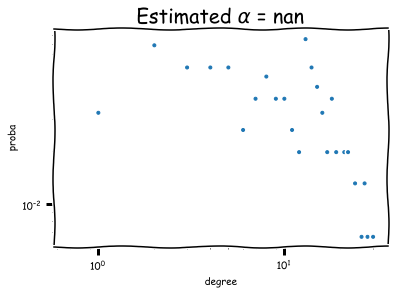

In [517]:
N = len(G.nodes())
counts = pdf
plt.loglog(degrees,counts,'.')
plt.xlabel('degree')
plt.ylabel('proba')

xlog = [np.log(c) for c in degrees]
ylog = [np.log(cnt) for cnt in pdf]
s = len(xlog)
newX = np.vstack([np.ones(s), xlog]).T
Beta1 = np.dot(np.dot(np.linalg.inv(np.dot(newX.T, newX)), newX.T), ylog)

idx = np.argsort(xlog)
yt = np.exp(newX[idx,:].dot(Beta1))
xt = np.exp(newX[idx,1])
plt.plot(xlog,ylog,'b',label='Data')
plt.loglog(xt,yt,'r', label='Line')
plt.title('Estimated $\\alpha$ = {0:1.4f}'.format(Beta1[1]), fontsize=20)



#### If we try to get regression we couldn't do that. Let's drop little part of data and try again.

Text(0.5,1,u'Estimated $\\alpha$ = -1.0097')

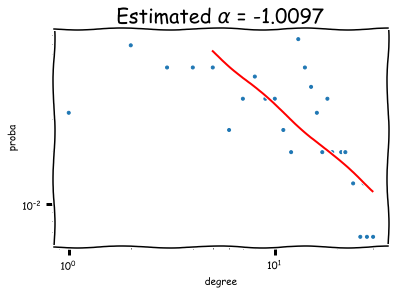

In [483]:
N = len(G.nodes())
counts = pdf
plt.loglog(degrees,counts,'.')
plt.xlabel('degree')
plt.ylabel('proba')

xlog = [np.log(c) for c in degrees[5:]]
ylog = [np.log(cnt) for cnt in pdf[5:]]
s = len(xlog)
newX = np.vstack([np.ones(s), xlog]).T
Beta1 = np.dot(np.dot(np.linalg.inv(np.dot(newX.T, newX)), newX.T), ylog)

idx = np.argsort(xlog)
yt = np.exp(newX[idx,:].dot(Beta1))
xt = np.exp(newX[idx,1])
plt.plot(xlog,ylog,'b',label='Data')
plt.loglog(xt,yt,'r', label='Line')
plt.title('Estimated $\\alpha$ = {0:1.4f}'.format(Beta1[1]), fontsize=20)



We has gotten the regression line but $1 < \alpha < 2$. Let's keep droping data until $\alpha < 2$

In [512]:
points = range(1,21)
best_points = 1
for point in points:
    N = len(G.nodes())
    counts = pdf
    xlog = [np.log(c) for c in degrees[point:]]
    ylog = [np.log(cnt) for cnt in pdf[point:]]
    s = len(xlog)
    newX = np.vstack([np.ones(s), xlog]).T
    Beta1 = np.dot(np.dot(np.linalg.inv(np.dot(newX.T, newX)), newX.T), ylog)
#     print Beta1[1]
    if np.abs(Beta1[1]) > 2:
        best_points = point
        print 'best points = ' + str(best_points)
        break
    



best points = 12


Text(0.5,1,u'Estimated $\\alpha$ = -2.2593')

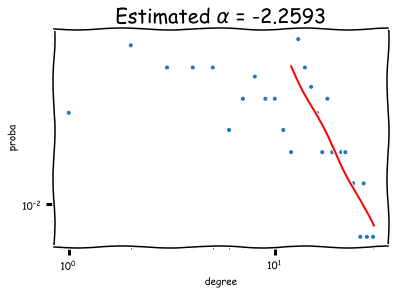

In [514]:
N = len(G.nodes())
counts = pdf
plt.loglog(degrees,counts,'.')
plt.xlabel('degree')
plt.ylabel('proba')
xlog = [np.log(c) for c in degrees[best_points:]]
ylog = [np.log(cnt) for cnt in pdf[best_points:]]
s = len(xlog)
newX = np.vstack([np.ones(s), xlog]).T
Beta1 = np.dot(np.dot(np.linalg.inv(np.dot(newX.T, newX)), newX.T), ylog)

idx = np.argsort(xlog)
yt = np.exp(newX[idx,:].dot(Beta1))
xt = np.exp(newX[idx,1])
plt.loglog(xt,yt,'r', label='Line')
plt.title('Estimated $\\alpha$ = {0:1.4f}'.format(Beta1[1]), fontsize=20)




#### Thus, we can get regression line with $\alpha > 2$ if we drop 12 points but it is almost all data we have. In common has shape as power law distribution.

### Compute different paraneters of the graph of friends

In [525]:
print 'max degree = ' + str(np.max(G.degree().values()))
print 'min degree = ' + str(np.min(G.degree().values()))
print 'mean degree = ' + str(np.mean(G.degree().values()))
print 'median degree = ' + str(np.median(G.degree().values()))

max degree = 30
min degree = 0
mean degree = 9.62091503268
median degree = 9.0


In [570]:
#Compute radius, diameter, average path length and clustering coefficient
clus_coef = nx.average_clustering(G)
print 'clustering coefficient = ' + str(clus_coef)
tempG = list(nx.connected_components(G))
GG = sorted(tempG, key = len, reverse=True)
GG = GG[0]
print 'average path length = '  + str(nx.average_shortest_path_length(G.subgraph(GG)))
print 'radius of the biggest component of G = ' +str(nx.radius(G.subgraph(GG)))
print 'diameter of the biggest component of G = ' + str(nx.diameter(G.subgraph(GG)))


clustering coefficient = 0.50260331509
average path length = 3.62744090442
radius of the biggest component of G = 5
diameter of the biggest component of G = 10



#### We can see that the clustering coefficient is high and average path length is small. It is similar with parameters of the graph from the real world.

## Let's compute different centrality measures

### degree centrality

In [58]:
degree_centr = nx.degree_centrality(friends)
sorted_degree_values = sorted(degree_centr.items(), key=lambda x: x[1], reverse=True)
degree_centr_values = np.array([v[1] for v in sorted_degree_values])
degree_centr_nodes = [v[0] for v in sorted_degree_values]
degree_interest_nodes = degree_centr_nodes[:10]
degree_color_values = ['r' if v in degree_interest_nodes else 'b' for v in degree_centr_nodes ]

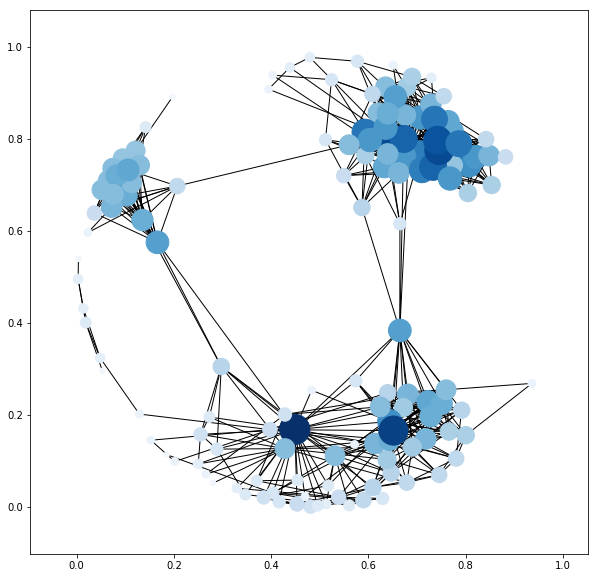

In [284]:
plt.figure(1, figsize=(10,10))
coord = nx.spring_layout(friends)
nx.draw_networkx(friends,
                 pos=coord, nodelist = degree_centr.keys(),
                 node_size = [d*4600 for d in degree_centr.values()],
                 node_color=[v * 10 for v in degree_centr.values()],#degree_color_values
                 font_size=7, with_labels = False,
                 cmap=plt.cm.Blues)

In [1871]:
for node in sorted_degree_values[:10]:
    print_info_about(node[0])
    print 'score = ' + str(node[1])
    

Just Ramzan
score = 0.197368421053
Джабраил Махаджиев
score = 0.184210526316
Валентина Шумовская
score = 0.177631578947
Тоня Соколова
score = 0.177631578947
Никита Козлов
score = 0.171052631579
Александра Степанюк
score = 0.157894736842
Женя Никишин
score = 0.157894736842
Виталий Минаев
score = 0.144736842105
Андрей Гайсин
score = 0.144736842105
Ольга Чемоданова
score = 0.144736842105


In [1870]:
node_name = degree_interest_nodes[0]
print_info_about(node_name)
print 'is the nickname of node ' + str(node_name) + ' with highest degree centrality' 

Just Ramzan
is the nickname of node 217318992 with highest degree centrality


#### He has higest degree centrality because he is acquainted with many friends of mine. It was not surprising to see these people at this list because we share many friends. 

### closeness centrality

In [101]:
close_centr = nx.closeness_centrality(friends)
sorted_close_centr = sorted(close_centr.items(), key = lambda x: x[1], reverse = True)
closeness_centr_values = np.array([v[1] for v in sorted_close_centr])
closeness_centr_nodes = [v[0] for v in sorted_close_centr]
close_interest_nodes = closeness_centr_nodes[:10]
close_color_values = ['r' if v in close_interest_nodes else 'b' for v in closeness_centr_nodes]

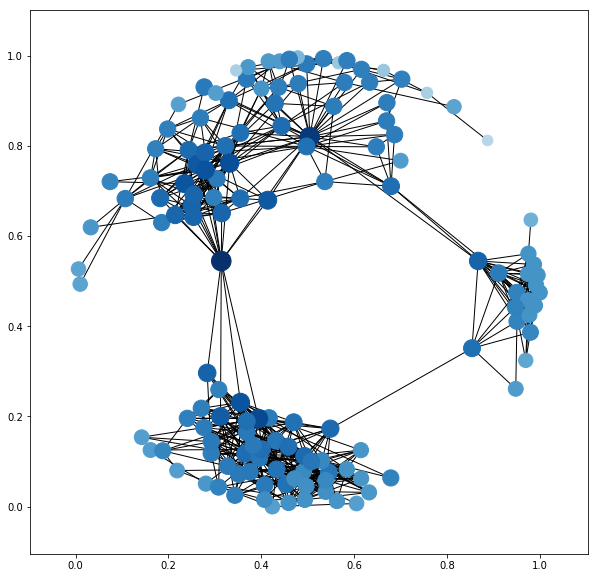

In [102]:
plt.figure(1, figsize=(10,10))
coord = nx.spring_layout(friends)
nx.draw_networkx(friends,
                 pos=coord,
                 nodelist=close_centr.keys(),
                 node_size = [d*1000 for d in close_centr.values()],
                 node_color=[d*1000 for d in close_centr.values()],#close_color_values,
                 font_size=6, with_labels = False,
                 cmap=plt.cm.Blues
                 )

In [1738]:
node_name = close_interest_nodes[0]
print_info_about(node_name)
print 'is the nickname of node ' + str(node_name) + ' with highest closeness centrality' 

Равида Мидова
is the nickname of node 278324789 with highest closeness centrality


In [63]:
for node in sorted_close_centr[:10]:
    print_info_about(node[0])
    
    print str(node[0]) + 'score = ' + str(node[1])

Равида Мидова
278324789score = 0.381717243559
Just Ramzan
217318992score = 0.3673752662
Александра Степанюк
83472701score = 0.343545519203
Алихан Шатойский
26726262score = 0.336274714564
Алена Парамонова
125261491score = 0.331020422149
Джабраил Махаджиев
177700250score = 0.331020422149
Хабиб Рашидов
264828785score = 0.326765660939
Залина Евлоева
182257288score = 0.321802131912
Равида Кабарда
137311679score = 0.320989500266
Aslan Bayramkulov
55491166score = 0.315414000261


#### She has highest closeness centrality because we have many friends in common and she is familiar with many friends of my friend's net. It was suprisied to see some people at this list. For example, Aleksandra Stepanuk it's not obvious she have high closeness centrality.

### betweeness centrality

In [103]:
between_centr = nx.betweenness_centrality(friends)
sorted_between_centr = sorted(between_centr.items(), key = lambda x: x[1], reverse = True)
betweenness_centr_values = np.array([v[1] for v in sorted_between_centr])
betweenness_centr_nodes = [v[0] for v in sorted_between_centr]
between_interest_nodes = betweenness_centr_nodes[:10]
between_color_values = ['r' if v in between_interest_nodes else 'b' for v in betweenness_centr_nodes]

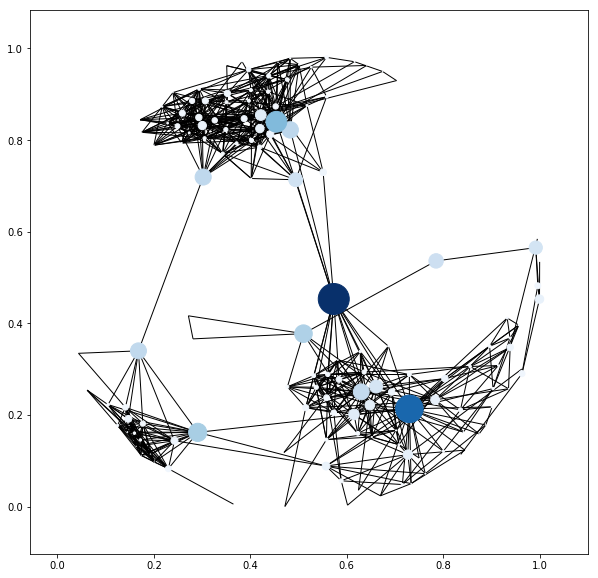

In [108]:
plt.figure(1, figsize=(10,10))
coord = nx.spring_layout(friends)
nx.draw_networkx(friends,
                 pos=coord,
                 nodelist=between_centr.keys(),
                 node_size = [d*3000 for d in between_centr.values()],
                 node_color=[d*20000 for d in between_centr.values()],#between_color_values,
                 font_size=6, with_labels = False, 
                 cmap=plt.cm.Blues
                 )

In [1873]:
for node in sorted_between_centr[:10]:
    print_info_about(node[0])
    print 'score = ' + str(node[1])

Равида Мидова
score = 0.319994281508
Just Ramzan
score = 0.252034540217
Александра Степанюк
score = 0.143183536044
Александра Курганова
score = 0.110020761664
Ibrahim Gurazhev
score = 0.103244681502
Алена Парамонова
score = 0.0891931984039
Александр Шепелёв
score = 0.0863211632072
Антон Смирнов
score = 0.0850373903988
Джабраил Махаджиев
score = 0.0830508734068
Александр Орстхоев
score = 0.0695364238411


In [1741]:
node_name = between_interest_nodes[0]
print_info_about(node_name)
print 'is the nickname of node ' + str(node_name) + ' with highest betweenness centrality' 

Равида Мидова
is the nickname of node 278324789 with highest betweenness centrality


#### She has highest betweenness centrality because many of my friends are familiar with each other through Равида Мидова. It means that most paths of friendship is going through her. Also she is tied between three groups of nodes. It was not surprised to see her at the first place at this list.

In [815]:
comG = nx.read_gml('community.gml')
coord = nx.spring_layout(comG)
# nx.draw_networkx(comG, coord,with_labels=True)

### Assortativity mixing

In [349]:
degree_assort_coef = nx.degree_assortativity_coefficient(G)
degree_assort_coef

0.10466197969251999

#### That means there are no many peaple who are acquainted with each other and have the same number of friends.

In [817]:
url = 'https://api.vk.com/method/users.get?user_ids=uid&fields=age,sex,city,followers_count&v=5.73'
resp=requests.get(url.replace('uid',str(friends_ids[97]))).json()[u'response']

In [484]:
sex = dict()
city = dict()
step = 0
for mid in friends_ids:
    step += 1
    print step
    resp=requests.get(url.replace('uid',str(mid))).json()[u'response']
    if resp[0].get('sex') != None:
        sex[resp[0]['id']] = str(resp[0]['sex'])
    if resp[0].get('city') != None:
        city[resp[0]['id']] = str(resp[0]['city']['id']) 
    



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153


In [483]:
sexG = friends.subgraph(sex.keys())
cityG = friends.subgraph(city.keys())

In [482]:
nx.set_node_attributes(sexG,'sex',sex)
nx.set_node_attributes(cityG,'city',city)

In [481]:
print 'assortativity of sex = ' + str(nx.assortativity.attribute_assortativity_coefficient(sexG,'sex'))
print 'assortativity of city =' + str(nx.assortativity.attribute_assortativity_coefficient(cityG, 'city'))

assortativity of sex = 0.176686595188
assortativity of city =-0.00286568105934


### Hence, there is a correlation between nodes with similar sex and correlation between nodes with different city

### PageRank

In [299]:
dirG = nx.DiGraph()
for friend_id in friends_ids:
    for fof in graph[friend_id]:
        if friend_id != fof and fof in friends_ids:
            dirG.add_edge(friend_id, fof)

In [300]:
rank = nx.pagerank(dirG)

In [301]:
sorted_rank = sorted(rank.items(), key = lambda x : x[1], reverse=True)
top_five_nodes = sorted_rank[:5]

In [302]:
for node in top_five_nodes:
    print_info_about(node[0])
    print 'rank score = ' + str(node[1])
    print '-'*40

Just Ramzan
rank score = 0.0222745168595
----------------------------------------
Джабраил Махаджиев
rank score = 0.0210813551752
----------------------------------------
Валентина Шумовская
rank score = 0.0148108791556
----------------------------------------
Алихан Шатойский
rank score = 0.013916275717
----------------------------------------
Ольга Чемоданова
rank score = 0.0134962874621
----------------------------------------


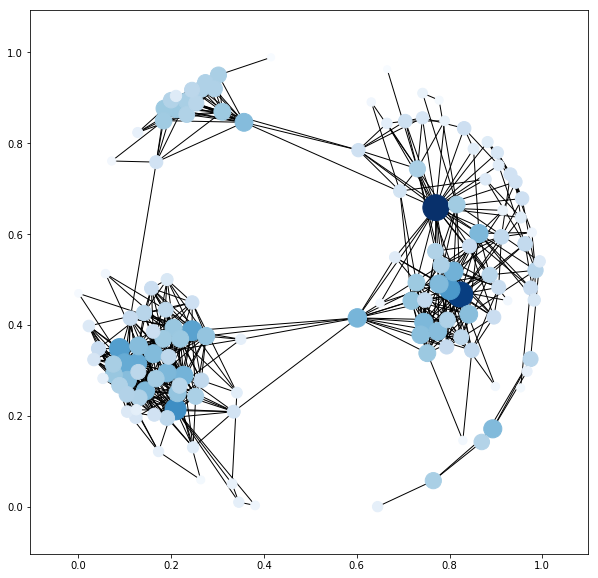

In [296]:
plt.figure(1, figsize=(10,10))
coord = nx.spring_layout(friends)
nx.draw_networkx(friends,
                 pos=coord, nodelist = [v[0] for v in sorted_rank],
                 node_size = [d[1]*30000 for d in sorted_rank],
                 node_color=[d[1] * 1000 for d in sorted_rank],#degree_color_values
                 font_size=7, with_labels = False,
                 cmap=plt.cm.Blues)

#### So we have gotten that nodes connecting largest communities have high betweeness and closeness centralities. Besides, nodes with high degree centrality have high PageRank

### Structural similarity

#### Jaccard similarity

In [1755]:
jaccard = nx.jaccard_coefficient(friends)
jaccard_simil = [(u,v,p) for u,v,p in jaccard]
sorted_jaccard_simil = sorted(jaccard_simil, key = lambda x: x[2], reverse = True)
print 'top 10 similar nodes'
for u,v,p in sorted_jaccard_simil[:10]:
#     print '({},{}) - {}'.format(str(print_info_about(u)),str(print_info_about(v)),p)
    str(print_info_about(u))
    str(print_info_about(v))
    print 'similarity score = ' + str(p)
    print'-'*40

top 10 similar nodes
Женя Иванов
Антон Шеленков
similarity score = 0.857142857143
----------------------------------------
Алексей Сальников
Сергей Шихов
similarity score = 0.818181818182
----------------------------------------
Зарема Сайгатова
Иса Хаджимурадов
similarity score = 0.8
----------------------------------------
Аня Цвирова
Женя Иванов
similarity score = 0.785714285714
----------------------------------------
Виктория Локшина
Nadya Ovsyannikova
similarity score = 0.785714285714
----------------------------------------
Зарема Сайгатова
Motsu Khadzhi
similarity score = 0.75
----------------------------------------
Виктория Локшина
Антон Шойхед
similarity score = 0.733333333333
----------------------------------------
Усман Джабраилов
Шамиль Нохчо
similarity score = 0.727272727273
----------------------------------------
Илья Павлов
Олег Дранов
similarity score = 0.666666666667
----------------------------------------
Майрбек Батаев
Берс Дараев
similarity score = 0.6666666666

In [371]:
cm = nx.utils.reverse_cuthill_mckee_ordering(G)
# get permutation
l = [n for n in cm]
A = nx.to_numpy_matrix(G,dtype=int)
A = np.asarray(A)

Text(0.5,1,u'Jaccard Dist.')

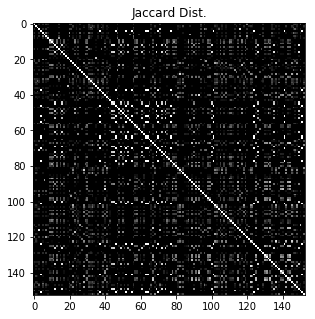

In [372]:
f, ax = plt.subplots(1, 1, figsize=(5,5))
    
dVec = spt.distance.pdist(A, metric = 'jaccard')
D = spt.distance.squareform(dVec)
ax.imshow(D, cmap = 'Greys', interpolation = 'None')
ax.set_title('Jaccard Dist.')


Text(0.5,1,u'Cosine Dist.')

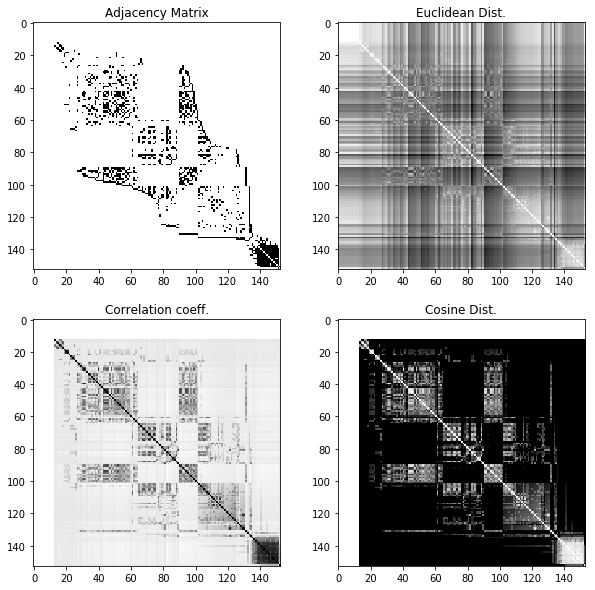

In [374]:
# run procedure



# apply reordering
A = A[np.ix_(l,l)]
f, ax = plt.subplots(2, 2, figsize=(10,10))
ax[0, 0].imshow(A, cmap = 'Greys', interpolation = 'None')
ax[0, 0].set_title('Adjacency Matrix')
    
D = np.corrcoef(A)
ax[1, 0].imshow(D, cmap = 'Greys', interpolation = 'None')
ax[1, 0].set_title('Correlation coeff.')
    
dVec = spt.distance.pdist(A, metric = 'euclidean')
D = spt.distance.squareform(dVec)
ax[0, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
ax[0, 1].set_title('Euclidean Dist.')
    
dVec = spt.distance.pdist(A, metric = 'cosine')
D = spt.distance.squareform(dVec)
ax[1, 1].imshow(D, cmap = 'Greys', interpolation = 'None')
ax[1, 1].set_title('Cosine Dist.')

### Model of the random graph

In [1878]:
max_deltas = dict()
nodes = len(friends.nodes())
probas = np.arange(0.001, 0.1,0.0001)
degree, cdf = empericalcdf(friends)
for p in probas:
    delta = []
    randG = nx.gnp_random_graph(nodes, p)
    degree_rand, cdf_rand = empericalcdf(randG)
    for ind in range(min(len(degree_rand), len(degree))):
        delta.append(np.abs(cdf_rand[ind] - cdf[ind]))
    max_deltas[p] =  np.max(delta)

In [1880]:
sorted_deltas = sorted(max_deltas.items(), key = lambda x: x[1])
optimal_p = sorted_deltas[0][0]
randG = nx.gnp_random_graph(nodes,optimal_p)

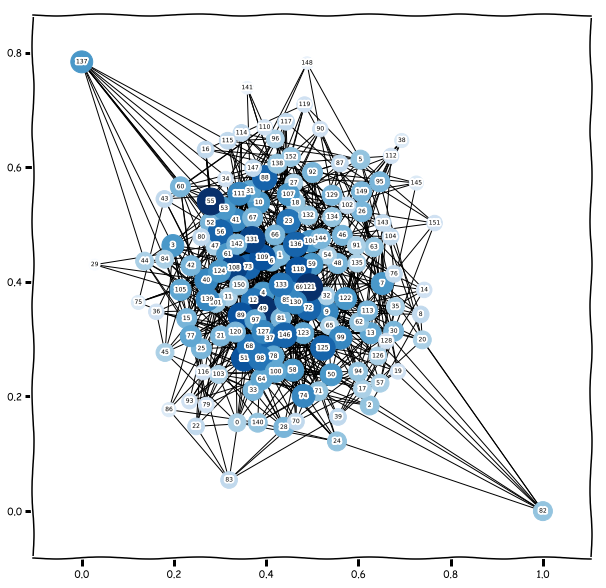

In [1881]:
plt.figure(1, figsize=(10,10))
coord = nx.spring_layout(randG)
randG_values = randG.degree().values()
nx.draw_networkx(randG,
                 pos=coord,
                 node_size = [d*40 for d in randG_values],
                 node_color=[d*40000 for d in randG_values],#katz_color_values,
                 font_size=6,
                 cmap=plt.cm.Blues
                 )

Text(0,0.5,u'proba')

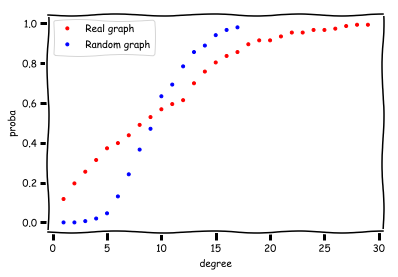

In [1882]:
degree_fr, cdf_fr = empericalcdf(friends)
degree_rand, cdf_rand = empericalcdf(randG)
fig, ax = plt.subplots()
ax.plot(degree_fr, cdf_fr,'.r',label = 'Real graph')
ax.plot(degree_rand, cdf_rand,'.b',label = 'Random graph')
plt.legend()
plt.xlabel('degree')
plt.ylabel('proba')

In [1883]:
print len(randG.nodes()), len(friends.nodes())
print len(randG.edges()), len(friends.edges())

153 153
763 736


In [1999]:
optimal_p

0.063800000000000023

In [1884]:
degree_rand, pdf_rand = empericalpdf(randG)
degree, pdf = empericalpdf(friends)

Text(0,0.5,u'proba')

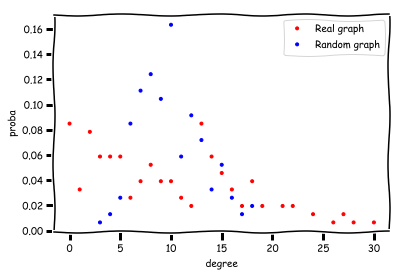

In [1885]:
fig, ax = plt.subplots()
ax.plot(degree, pdf,'.r',label = 'Real graph')
ax.plot(degree_rand, pdf_rand,'.b',label = 'Random graph')
plt.legend()
plt.xlabel('degree')
plt.ylabel('proba')

In [1886]:
print 'For graph of friends'
print '-'*40
print 'max degree = ' + str(np.max(friends.degree().values()))
print 'min degree = ' + str(np.min(friends.degree().values()))
print 'mean degree = ' + str(np.mean(friends.degree().values()))
print 'median degree = ' + str(np.median(friends.degree().values()))
print '-'*40
clus_coef = nx.average_clustering(friends)
print 'clustering coefficient = ' + str(clus_coef)
tmpG = list(nx.connected_components(friends))
GG = sorted(tmpG, key = len, reverse=True)
GG = GG[0]
print 'average path length = '  + str(nx.average_shortest_path_length(friends.subgraph(GG)))
print 'radius of the biggest component of G = ' +str(nx.radius(friends.subgraph(GG)))
print 'diameter of the biggest component of G = ' + str(nx.diameter(friends.subgraph(GG)))
print '-'*40

For graph of friends
----------------------------------------
max degree = 30
min degree = 0
mean degree = 9.62091503268
median degree = 9.0
----------------------------------------
clustering coefficient = 0.50260331509
average path length = 3.62744090442
radius of the biggest component of G = 5
diameter of the biggest component of G = 10
----------------------------------------


In [1887]:
max_degree = []
min_degree = []
mean_degree = []
median_degree = []
cluster_values = []
avr_path_length = []
radius = []
diameter = []
for ind in range(40):
    tG = nx.gnp_random_graph(nodes,optimal_p)
    max_degree.append(np.max(tG.degree().values()))
    min_degree.append(np.min(tG.degree().values()))
    median_degree.append(np.median(tG.degree().values()))
    mean_degree.append(np.mean(tG.degree().values()))
    cluster_values.append(nx.average_clustering(tG))
    tmpG = list(nx.connected_components(tG))
    GG = sorted(tmpG, key = len, reverse=True)
    GG = GG[0]
    avr_path_length.append(nx.average_shortest_path_length(tG.subgraph(GG)))
    radius.append(nx.radius(tG.subgraph(GG)))
    diameter.append(nx.diameter(tG.subgraph(GG)))
    
print 'For random graph of friends'
print '-'*40
print 'max degree = ' + str(np.mean(max_degree))
print 'min degree = ' + str(np.mean(min_degree))
print 'mean degree = ' + str(np.mean(mean_degree))
print 'median degree = ' + str(np.mean(median_degree))
print '-'*40
clus_coef = nx.average_clustering(randG)
print 'average clustering coefficient = ' + str(np.mean(cluster_values))
print 'average path length = '  + str(np.mean(avr_path_length))
print 'radius of the biggest component of G = ' +str(np.mean(radius))
print 'diameter of the biggest component of G = ' + str(np.mean(diameter))
print '-'*40

For random graph of friends
----------------------------------------
max degree = 18.375
min degree = 2.85
mean degree = 9.65392156863
median degree = 9.45
----------------------------------------
average clustering coefficient = 0.0629821401236
average path length = 2.4594878741
radius of the biggest component of G = 3.0
diameter of the biggest component of G = 4.05
----------------------------------------


### As we can see from the reports above the random graph and initial graph of friends have close values of mean and  median degree. But other parameters are different.

#### degree centrality

In [1918]:
degree_centr = nx.degree_centrality(randG)
sorted_degree_values = sorted(degree_centr.items(), key=lambda x: x[1], reverse=True)
rand_degree_values = np.array([v[1] for v in sorted_degree_values])
# rand_degree_nodes = [v[0] for v in sorted_degree_values]
print 'top 10 nodes with high values of degree centrality'
# top_ten = [v[0] for v in sorted_degree_values[:10]]
for key, val in sorted_degree_values[:10]:
    print key, val

top 10 nodes with high values of degree centrality
49 0.118421052632
55 0.118421052632
121 0.118421052632
108 0.111842105263
131 0.111842105263
51 0.105263157895
89 0.105263157895
109 0.105263157895
118 0.105263157895
37 0.0986842105263


#### betweenness centrality

In [1941]:
between_centr = nx.betweenness_centrality(randG)
sorted_between_centr = sorted(between_centr.items(), key = lambda x: x[1], reverse = True)
rand_between_values = np.array([v[1] for v in sorted_between_centr])
# top_ten = [v[0] for v in sorted_close_centr[:10]]
print 'top 10 nodes with high values of betweenness centrality'
for key, val in sorted_between_centr[:10]:
    print key, val

top 10 nodes with high values of betweenness centrality
121 0.0305563131371
55 0.0297086140737
49 0.0280862818111
131 0.0280000022661
109 0.0251093104853
51 0.0224312277924
108 0.0223545964831
118 0.0217077848866
136 0.0209481857755
56 0.0205859326361


#### closeness centrality

In [1942]:
close_centr = nx.closeness_centrality(randG)
sorted_close_centr = sorted(close_centr.items(), key = lambda x: x[1], reverse = True)
rand_close_values = np.array([v[1] for v in sorted_close_centr])
# top_ten = [v[0] for v in sorted_close_centr[:10]]
print 'top 10 nodes with high values of closeness centrality'
for key, val in sorted_close_centr[:10]:
    print key, val

top 10 nodes with high values of closeness centrality
49 0.475
55 0.472049689441
109 0.472049689441
121 0.467692307692
51 0.464831804281
131 0.463414634146
37 0.459214501511
89 0.459214501511
72 0.453731343284
73 0.453731343284


#### Compare centrality measures of random graph with centrality measures of graph of friends

In [1972]:
delta_degree = np.linalg.norm(degree_centr_values - rand_degree_values)
print 'delta of degree = ' + str(delta_degree)

delta of degree = 0.328815763147


In [1973]:
delta_betweenness = np.linalg.norm(betweenness_centr_values - rand_between_values)
print 'delta of between = ' + str(delta_betweenness)

delta of between = 0.431836998672


In [1974]:
delta_closeness = np.linalg.norm(closeness_centr_values - rand_close_values)
print 'delta of between = ' + str(delta_closeness)

delta of between = 2.31623750981


### Preferential attachment model

In [1519]:
def uniform_attach(G,m,count_nodes):
    if m > len(G.nodes()):
        print 'Please, choose anoter m <= ' + str(len(G.nodes()))
        return
    newG = nx.Graph(G)
    step = len(G.nodes())
    while step < count_nodes:
        ind = 0
        step += 1 
        all_nodes = newG.nodes()
        adding_node = np.max(all_nodes) + 1 
        newG.add_node(adding_node)
        while ind < m:
#             chosen = np.random.randint(low=np.min(all_nodes), high=np.max(all_nodes))
            chosen = np.random.choice(all_nodes)
            if not newG.has_edge(adding_node, chosen):
                newG.add_edge(adding_node, chosen)
                ind += 1
            
    return newG

In [1520]:
def compute_probas(G):
    all_nodes = G.nodes()
    degree_nodes = [G.degree(node) for node in all_nodes]
    sum_degrees = np.sum(degree_nodes)
    nodes_probas = [float(x) / sum_degrees for x in degree_nodes]
    return nodes_probas
    

def prefer_attach(G,m,count_steps):
    if m > len(G.nodes()):
        print 'Please, choose another m <= ' + str(len(G.nodes()))
        return None
    step = len(G.nodes())
    newG = nx.Graph(G)

    while step < count_steps:
        ind = 0
        all_nodes = newG.nodes()
        new_node = np.max(all_nodes) + 1
        node_probas = compute_probas(newG)
        newG.add_node(new_node)
        while ind < m:
            chosen1 = np.random.choice(all_nodes, p = node_probas)
            if not newG.has_edge(new_node, chosen1):
                newG.add_edge(new_node, chosen1)
                ind += 1
        step += 1
    return newG
            
    

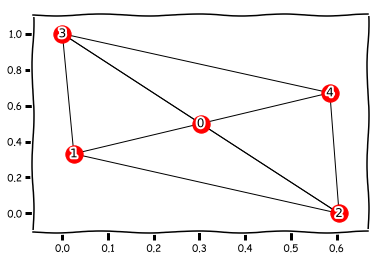

In [1521]:
tempG = nx.Graph()
tempG.add_nodes_from([0,1,2,3,4])
tempG.add_edges_from([(0,1),(1,2),(0,2),(1,3),(2,3),(0,3),(2,4),(4,3),(4,0)])
nx.draw_networkx(tempG)
# PrefG = prefer_attach(tempG,5,len(G.nodes()))

#### Computing optimal values of m

In [1891]:
max_deltas = dict()
nodes = len(friends.nodes())
m = len(tempG.nodes())
ms = range(1, m+1)
degree, cdf = empericalcdf(friends)
for tm in ms:
    delta = []
    PrefG = prefer_attach(tempG,tm, nodes)
    degree_pref, cdf_pref = empericalcdf(PrefG)
    for ind in range(min(len(degree_pref), len(degree))):
        delta.append(np.abs(cdf_pref[ind] - cdf[ind]))
    max_deltas[tm] =  np.max(delta)

In [1898]:
sorted_deltas = sorted(max_deltas.items(), key = lambda x: x[1])
optimal_m = sorted_deltas[0][0]
PrefG = prefer_attach(tempG, optimal_m, nodes)

In [1899]:
print len(PrefG.nodes()), len(friends.nodes())
print len(PrefG.edges()), len(friends.edges())

153 153
601 736


Text(0,0.5,u'proba')

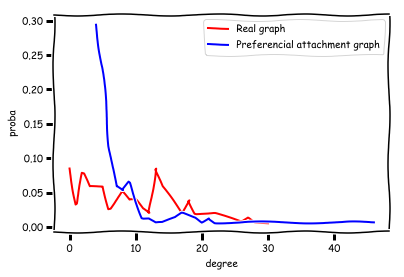

In [1900]:
degree_rand, pdf_rand = empericalpdf(PrefG)
degree, pdf = empericalpdf(friends)
fig, ax = plt.subplots()
ax.plot(degree, pdf,'r',label = 'Real graph')
ax.plot(degree_rand, pdf_rand,'b',label = 'Preferencial attachment graph')
plt.legend()
plt.xlabel('degree')
plt.ylabel('proba')

Text(0,0.5,u'proba')

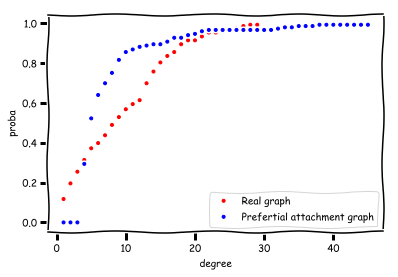

In [1901]:
degree_fr, cdf_fr = empericalcdf(friends)
degree_pref, cdf_pref = empericalcdf(PrefG)
fig, ax = plt.subplots()
ax.plot(degree_fr, cdf_fr,'.r',label = 'Real graph')
ax.plot(degree_pref, cdf_pref,'.b',label = 'Prefertial attachment graph')
plt.legend()
plt.xlabel('degree')
plt.ylabel('proba')

In [1902]:
print 'For graph of friends'
print '-'*40
print 'max degree = ' + str(np.max(friends.degree().values()))
print 'min degree = ' + str(np.min(friends.degree().values()))
print 'mean degree = ' + str(np.mean(friends.degree().values()))
print 'median degree = ' + str(np.median(friends.degree().values()))
print '-'*40
clus_coef = nx.average_clustering(friends)
print 'clustering coefficient = ' + str(clus_coef)
tmpG = list(nx.connected_components(friends))
GG = sorted(tmpG, key = len, reverse=True)
GG = GG[0]
print 'average path length = '  + str(nx.average_shortest_path_length(friends.subgraph(GG)))
print 'radius of the biggest component of G = ' +str(nx.radius(friends.subgraph(GG)))
print 'diameter of the biggest component of G = ' + str(nx.diameter(friends.subgraph(GG)))
print '-'*40

For graph of friends
----------------------------------------
max degree = 30
min degree = 0
mean degree = 9.62091503268
median degree = 9.0
----------------------------------------
clustering coefficient = 0.50260331509
average path length = 3.62744090442
radius of the biggest component of G = 5
diameter of the biggest component of G = 10
----------------------------------------


In [1906]:
max_degree = []
min_degree = []
mean_degree = []
median_degree = []
cluster_values = []
avr_path_length = []
radius = []
diameter = []
for ind in range(40):
    PrefG = prefer_attach(tempG,optimal_m,len(friends.nodes()))
    max_degree.append(np.max(PrefG.degree().values()))
    min_degree.append(np.min(PrefG.degree().values()))
    median_degree.append(np.median(PrefG.degree().values()))
    mean_degree.append(np.mean(PrefG.degree().values()))
    cluster_values.append(nx.average_clustering(PrefG))
    tmpG = list(nx.connected_components(PrefG))
    GG = sorted(tmpG, key = len, reverse=True)
    GG = GG[0]
    avr_path_length.append(nx.average_shortest_path_length(PrefG.subgraph(GG)))
    radius.append(nx.radius(PrefG.subgraph(GG)))
    diameter.append(nx.diameter(PrefG.subgraph(GG)))
    
print 'For random graph of friends'
print '-'*40
print 'max degree = ' + str(np.mean(max_degree))
print 'min degree = ' + str(np.mean(min_degree))
print 'mean degree = ' + str(np.mean(mean_degree))
print 'median degree = ' + str(np.mean(median_degree))
print '-'*40
clus_coef = nx.average_clustering(randG)
print 'average clustering coefficient = ' + str(np.mean(cluster_values))
print 'average path length = '  + str(np.mean(avr_path_length))
print 'radius of the biggest component of G = ' +str(np.mean(radius))
print 'diameter of the biggest component of G = ' + str(np.mean(diameter))
print '-'*40

For random graph of friends
----------------------------------------
max degree = 41.975
min degree = 4.0
mean degree = 7.85620915033
median degree = 5.4
----------------------------------------
average clustering coefficient = 0.134292267243
average path length = 2.52511179911
radius of the biggest component of G = 2.95
diameter of the biggest component of G = 4.0
----------------------------------------


### As we can see from the reports above the random graph and initial graph of friends have close values of mean degree. But other parameters are different.

#### degree centrality

In [1947]:
degree_centr = nx.degree_centrality(PrefG)
sorted_degree_values = sorted(degree_centr.items(), key=lambda x: x[1], reverse=True)
pref_degree_values = np.array([v[1] for v in sorted_degree_values])
print 'top 10 nodes with high values of degree centrality'
# top_ten = [v[0] for v in sorted_degree_values[:10]]
for key, val in sorted_degree_values[:10]:
    print key, val

top 10 nodes with high values of degree centrality
3 0.256578947368
4 0.197368421053
1 0.190789473684
5 0.171052631579
8 0.164473684211
26 0.157894736842
0 0.151315789474
11 0.151315789474
12 0.151315789474
2 0.144736842105


#### closeness centrality

In [1948]:
close_centr = nx.closeness_centrality(PrefG)
sorted_close_centr = sorted(close_centr.items(), key = lambda x: x[1], reverse = True)
pref_close_values = np.array([v[1] for v in sorted_close_centr])
# top_ten = [v[0] for v in sorted_close_centr[:10]]
print 'top 10 nodes with high values of closeness centrality'
for key, val in sorted_close_centr[:10]:
    print key, val

top 10 nodes with high values of closeness centrality
3 0.554744525547
1 0.529616724739
4 0.520547945205
5 0.515254237288
2 0.513513513514
8 0.508361204013
0 0.490322580645
11 0.490322580645
6 0.48253968254
7 0.473520249221


#### betweeness centrality

In [1949]:
between_centr = nx.betweenness_centrality(PrefG)
sorted_between_centr = sorted(between_centr.items(), key = lambda x: x[1], reverse = True)
pref_between_values = np.array([v[1] for v in sorted_between_centr])
# top_ten = [v[0] for v in sorted_close_centr[:10]]
print 'top 10 nodes with high values of betweenness centrality'
for key, val in sorted_between_centr[:10]:
    print key, val

top 10 nodes with high values of betweenness centrality
3 0.147296522683
1 0.0838605209854
4 0.081531573433
8 0.0675258303007
5 0.0639273188062
12 0.0555657154748
0 0.0540478431347
11 0.0519883326302
26 0.0461166058932
2 0.0439291879974


#### eigenvector centrality

In [1611]:
eigen_centr = nx.eigenvector_centrality(PrefG)
sorted_eigen_centr = sorted(eigen_centr.items(), key = lambda x: x[1], reverse = True)
# top_ten = [v[0] for v in sorted_close_centr[:10]]
print 'top 10 nodes with high values of eigenvector centrality'
for key, val in sorted_eigen_centr[:10]:
    print key, val

top 10 nodes with high values of eigenvector centrality
2 0.329453571138
3 0.298856629501
6 0.268653207168
0 0.263021325529
7 0.206445652956
1 0.197755450485
12 0.184664304336
4 0.165587714577
10 0.155081854942
8 0.14860512673


#### Compare centrality measures of model graph with centrality measures of graph of friends

In [1969]:
delta_degree = np.linalg.norm(degree_centr_values - pref_degree_values)
print 'delta of degree = ' + str(delta_degree)

delta of degree = 0.314828581948


In [1970]:
delta_close = np.linalg.norm(closeness_centr_values - pref_close_values)
print 'delta of degree = ' + str(delta_close)

delta of degree = 2.08330836148


In [1971]:
delta_between = np.linalg.norm(betweenness_centr_values - pref_between_values)
print 'delta of degree = ' + str(delta_close)

delta of degree = 2.08330836148


### Uniform attachment model

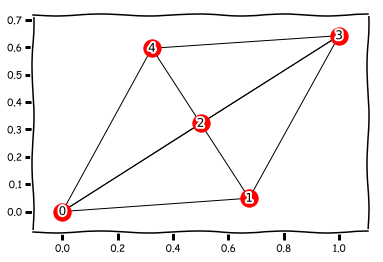

In [1910]:
tempG = nx.Graph()
tempG.add_nodes_from([0,1,2,3,4])
tempG.add_edges_from([(0,1),(1,2),(0,2),(1,3),(2,3),(0,3),(2,4),(4,3),(4,0)])
nx.draw_networkx(tempG)

In [1911]:
max_deltas = dict()
nodes = len(friends.nodes())
m = len(tempG.nodes())
ms = range(1, m+1)
degree, cdf = empericalcdf(friends)
for tm in ms:
    delta = []
    UnifG = uniform_attach(tempG, tm, len(friends.nodes()))
    degree_unif, cdf_unif = empericalcdf(UnifG)
    for ind in range(min(len(degree_unif), len(degree))):
        delta.append(np.abs(cdf_unif[ind] - cdf[ind]))
    max_deltas[tm] =  np.max(delta)

In [1912]:
sorted_deltas = sorted(max_deltas.items(), key = lambda x: x[1])
optimal_m = sorted_deltas[0][0]
UnifG = uniform_attach(tempG, optimal_m, len(friends.nodes()))

Text(0,0.5,u'proba')

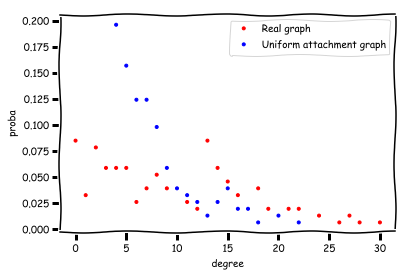

In [1913]:
degree_rand, pdf_rand = empericalpdf(UnifG)
degree, pdf = empericalpdf(friends)
fig, ax = plt.subplots()
ax.plot(degree, pdf,'.r',label = 'Real graph')
ax.plot(degree_rand, pdf_rand,'.b',label = 'Uniform attachment graph')
plt.legend()
plt.xlabel('degree')
plt.ylabel('proba')

Text(0,0.5,u'proba')

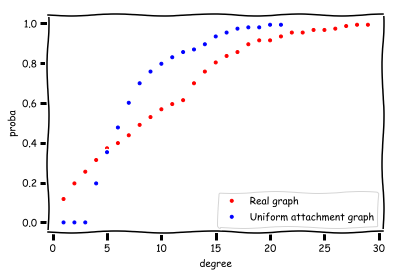

In [1914]:
degree_fr, cdf_fr = empericalcdf(friends)
degree_unif, cdf_unif = empericalcdf(UnifG)
fig, ax = plt.subplots()
ax.plot(degree_fr, cdf_fr,'.r',label = 'Real graph')
ax.plot(degree_unif, cdf_unif,'.b',label = 'Uniform attachment graph')
plt.legend()
plt.xlabel('degree')
plt.ylabel('proba')

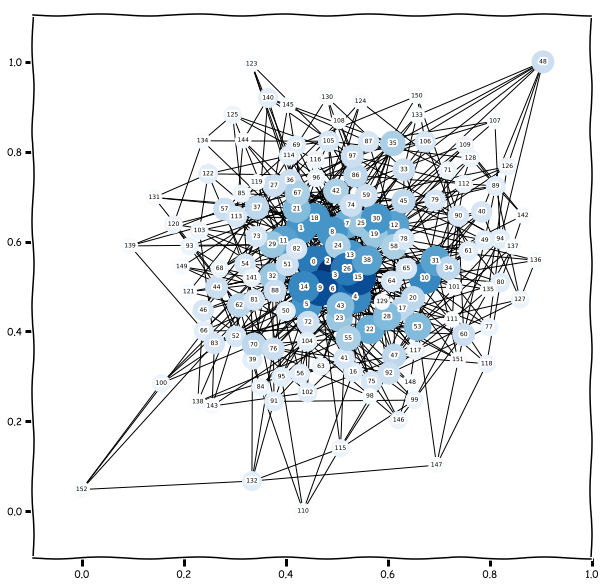

In [1915]:
plt.figure(1, figsize=(10,10))
coord = nx.spring_layout(UnifG)
unifG_values = UnifG.degree().values()
nx.draw_networkx(UnifG,
                 pos=coord,
                 node_size = [d*60 for d in unifG_values],
                 node_color=[d*40000 for d in unifG_values],
                 font_size=6,
                 cmap=plt.cm.Blues
                 )

In [1576]:
print 'For graph of friends'
print '-'*40
print 'max degree = ' + str(np.max(G.degree().values()))
print 'min degree = ' + str(np.min(G.degree().values()))
print 'mean degree = ' + str(np.mean(G.degree().values()))
print 'median degree = ' + str(np.median(G.degree().values()))
print '-'*40
clus_coef = nx.average_clustering(G)
print 'clustering coefficient = ' + str(clus_coef)
tmpG = list(nx.connected_components(G))
GG = sorted(tmpG, key = len, reverse=True)
GG = GG[0]
print 'average path length = '  + str(nx.average_shortest_path_length(G.subgraph(GG)))
print 'radius of the biggest component of G = ' +str(nx.radius(G.subgraph(GG)))
print 'diameter of the biggest component of G = ' + str(nx.diameter(G.subgraph(GG)))
print '-'*40

For graph of friends
----------------------------------------
max degree = 30
min degree = 0
mean degree = 9.62091503268
median degree = 9.0
----------------------------------------
clustering coefficient = 0.50260331509
average path length = 3.62744090442
radius of the biggest component of G = 5
diameter of the biggest component of G = 10
----------------------------------------


In [1577]:
max_degree = []
min_degree = []
mean_degree = []
median_degree = []
cluster_values = []
avr_path_length = []
radius = []
diameter = []
for ind in range(40):
    UnifG = uniform_attach(tempG,optimal_m,len(G.nodes()))
    max_degree.append(np.max(UnifG.degree().values()))
    min_degree.append(np.min(UnifG.degree().values()))
    median_degree.append(np.median(UnifG.degree().values()))
    mean_degree.append(np.mean(UnifG.degree().values()))
    cluster_values.append(nx.average_clustering(UnifG))
    tmpG = list(nx.connected_components(UnifG))
    GG = sorted(tmpG, key = len, reverse=True)
    GG = GG[0]
    avr_path_length.append(nx.average_shortest_path_length(UnifG.subgraph(GG)))
    radius.append(nx.radius(UnifG.subgraph(GG)))
    diameter.append(nx.diameter(UnifG.subgraph(GG)))
    
print 'For random graph of friends'
print '-'*40
print 'max degree = ' + str(np.mean(max_degree))
print 'min degree = ' + str(np.mean(min_degree))
print 'mean degree = ' + str(np.mean(mean_degree))
print 'median degree = ' + str(np.mean(median_degree))
print '-'*40
clus_coef = nx.average_clustering(randG)
print 'average clustering coefficient = ' + str(np.mean(cluster_values))
print 'average path length = '  + str(np.mean(avr_path_length))
print 'radius of the biggest component of G = ' +str(np.mean(radius))
print 'diameter of the biggest component of G = ' + str(np.mean(diameter))
print '-'*40

For random graph of friends
----------------------------------------
max degree = 22.2
min degree = 4.0
mean degree = 7.85620915033
median degree = 6.7
----------------------------------------
average clustering coefficient = 0.0661450356409
average path length = 2.66067251462
radius of the biggest component of G = 3.0
diameter of the biggest component of G = 4.475
----------------------------------------


#### Unfortunately, at this case there are no close values of parameters

#### degree centrality

In [1959]:
degree_centr = nx.degree_centrality(UnifG)
sorted_degree_values = sorted(degree_centr.items(), key=lambda x: x[1], reverse=True)
unif_degree_values = np.array([v[1] for v in sorted_degree_values])
print 'top 10 nodes with high values of degree centrality'
# top_ten = [v[0] for v in sorted_degree_values[:10]]
for key, val in sorted_degree_values[:10]:
    print key, val

top 10 nodes with high values of degree centrality
3 0.144736842105
9 0.131578947368
15 0.131578947368
6 0.118421052632
0 0.111842105263
2 0.111842105263
26 0.111842105263
4 0.105263157895
10 0.105263157895
14 0.105263157895


#### closeness centrality

In [1960]:
close_centr = nx.closeness_centrality(UnifG)
sorted_close_centr = sorted(close_centr.items(), key = lambda x: x[1], reverse = True)
unif_close_values = np.array([v[1] for v in sorted_close_centr])
# top_ten = [v[0] for v in sorted_close_centr[:10]]
print 'top 10 nodes with high values of closeness centrality'
for key, val in sorted_close_centr[:10]:
    print key, val

top 10 nodes with high values of closeness centrality
3 0.477987421384
9 0.464831804281
0 0.463414634146
15 0.455089820359
4 0.452380952381
6 0.452380952381
26 0.449704142012
13 0.448377581121
10 0.443148688047
14 0.443148688047


#### betweenness centrality

In [1961]:
between_centr = nx.betweenness_centrality(UnifG)
sorted_between_centr = sorted(between_centr.items(), key = lambda x: x[1], reverse = True)
unif_between_values = np.array([v[1] for v in sorted_between_centr])
# top_ten = [v[0] for v in sorted_close_centr[:10]]
print 'top 10 nodes with high values of betweenness centrality'
for key, val in sorted_between_centr[:10]:
    print key, val

top 10 nodes with high values of betweenness centrality
3 0.0539980236094
15 0.0507509678582
9 0.0504349158132
26 0.0449098175924
6 0.0405529963141
30 0.0336126987234
2 0.032981802569
10 0.0329114947447
38 0.0327126421029
14 0.0324477916691


#### Compare centrality measures of  the model graph with centrality measures of the graph of friends

In [1966]:
delta_degree = np.linalg.norm(degree_centr_values - unif_degree_values)
print 'delta of degree = ' + str(delta_degree)

delta of degree = 0.315652382524


In [1967]:
delta_close = np.linalg.norm(closeness_centr_values - unif_close_values)
print 'delta of degree = ' + str(delta_close)

delta of degree = 1.90210861456


In [1968]:
delta_between = np.linalg.norm(betweenness_centr_values - unif_between_values)
print 'delta of degree = ' + str(delta_between)

delta of degree = 0.381303346513


### Small world model

In [1976]:
def gen_regular_graph(n, k):
    G = nx.Graph()
    nodes = list(range(n))
    for j in range(1, k // 2+1):
        targets = nodes[j:] + nodes[0:j] # first j nodes are now last in list
        G.add_edges_from(zip(nodes,targets))
    return G
def rewire(G, p):
    for node in G.nodes():
        for edge in G.neighbors(node):
            not_connected = [vert for vert in G.nodes() if vert != node and not G.has_edge(node,vert)]
            proba = np.random.random()
            if proba < p:
                G.add_edge(node, not_connected[np.random.randint(0,len(not_connected)-1)])
                G.remove_edge(node,edge)
    return G        

#### My graph of friends has 153 nodes, n*k % 2 ==  0. Hence k must be k % 2 == 0

In [322]:
# regG = nx.random_regular_graph(2,len(friends.nodes()))
probas = np.arange(0.05,1,0.01)
ks = np.arange(2,18,2)
nodes = len(friends.nodes())
degree, cdf = empericalcdf(friends)

In [323]:
params = dict()
for p in probas:
    for k in ks:
        temp = []
        smallG = nx.watts_strogatz_graph(nodes, k, p)
        degree_small, cdf_small = empericalcdf(smallG)
        
        for ind in range(min(len(degree_small), len(degree))):
            temp.append(np.abs(cdf_small[ind] - cdf[ind]))
            
        params[(p,k)] = np.max(temp)
        

In [324]:
sorted_params = sorted(params.items(), key = lambda x: x[1])

In [325]:
optimal_p = sorted_params[0][0][0]
optimal_k = sorted_params[0][0][1]
best_smallG = nx.watts_strogatz_graph(nodes, optimal_k, optimal_p)

In [326]:
small_degree, small_cdf = empericalcdf(best_smallG)
degree, cdf = empericalcdf(friends)
degree_pdf, pdf = empericalpdf(friends)
small_degree_pdf, small_pdf = empericalpdf(best_smallG)

Text(0,0.5,u'proba')

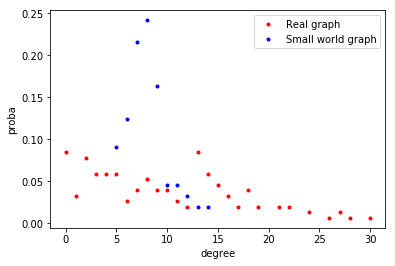

In [327]:
fig, ax = plt.subplots()
ax.plot(degree_pdf, pdf,'.r',label = 'Real graph')
ax.plot(small_degree_pdf, small_pdf,'.b',label = 'Small world graph')
plt.legend()
plt.xlabel('degree')
plt.ylabel('proba')

Text(0,0.5,u'proba')

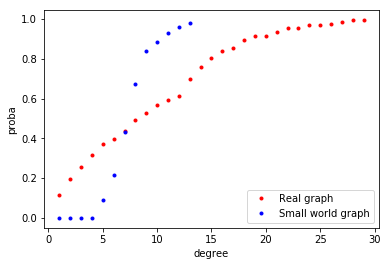

In [328]:

fig, ax = plt.subplots()
ax.plot(degree, cdf,'.r',label = 'Real graph')
ax.plot(small_degree, small_cdf,'.b',label = 'Small world graph')
plt.legend()
plt.xlabel('degree')
plt.ylabel('proba')

### So we have gotten that the best model is similar to graph of friends is prefernitail attachment model.

## Community detection

In [156]:
from networkx.algorithms.clique import find_cliques

#### Let's find 'cliques on >= 3 nodes

In [185]:
cliques = find_cliques(friends)
  

In [175]:
for val in cliques:
    if len(val) >= 3:
        print val
        for ind in range(len(val)):
            print_info_about(val[ind])
        print '-'*40  

[11806979, 21878656, 53796935, 9908290, 29758310, 10577351, 9728367, 13150931, 18258932, 182381110, 50170028]
Nadya Ovsyannikova
Саша Суворов
Михаил Климов
Михаил Гулюкин
Алена Лихаева
Александра Курганова
Никита Агаев
Антон Шойхед
Михаил Кузнецов
Lera Savostina
Женя Иванов
----------------------------------------
[11806979, 21878656, 53796935, 9908290, 29758310, 10577351, 9728367, 13150931, 18258932, 182381110, 21281012, 22175897]
Nadya Ovsyannikova
Саша Суворов
Михаил Климов
Михаил Гулюкин
Алена Лихаева
Александра Курганова
Никита Агаев
Антон Шойхед
Михаил Кузнецов
Lera Savostina
Антон Шеленков
Аня Цвирова
----------------------------------------
[11806979, 21878656, 53796935, 9311459, 50170028]
Nadya Ovsyannikova
Саша Суворов
Михаил Климов
Саша Жутяева
Женя Иванов
----------------------------------------
[191966980, 55600321, 17857646, 131642427, 31689128, 21368376]
Виталий Минаев
Андрей Тощев
Валентина Шумовская
Азиз Тагаев
Женя Никишин
Вадим Навражных
-----------------------------

Aysha Ayshat
----------------------------------------
[219992074, 137283709, 11784762]
Шарип Умханов
Дети Чечни
Jack Abrek
----------------------------------------
[219992074, 137283709, 98567791]
Шарип Умханов
Дети Чечни
Адам Мусаев
----------------------------------------
[219992074, 177700250, 98567791]
Шарип Умханов
Джабраил Махаджиев
Адам Мусаев
----------------------------------------
[324837336, 144038882, 174687642, 177700250, 173711816, 33724097, 312131569, 30611533, 157526635]
Мурад Идалов
Абдаллах Изарипов
Бекман Мусостов
Джабраил Махаджиев
Мансур Бекмурзаев
Рамзан Межидов
Тамерлан Зеликов
Шамиль Алаев
Усман Джабраилов
----------------------------------------
[324837336, 144038882, 174687642, 177700250, 173711816, 33724097, 312131569, 30611533, 6492974]
Мурад Идалов
Абдаллах Изарипов
Бекман Мусостов
Джабраил Махаджиев
Мансур Бекмурзаев
Рамзан Межидов
Тамерлан Зеликов
Шамиль Алаев
Шамиль Нохчо
----------------------------------------
[324837336, 144038882, 174687642, 17770025

Karina Isaeva
Залина Евлоева
Джабраил Махаджиев
Датика Ренина
Milana Khamidova
----------------------------------------
[259671336, 182257288, 177700250, 27601407, 10709747]
Karina Isaeva
Залина Евлоева
Джабраил Махаджиев
Датика Ренина
Белла Гаургаева
----------------------------------------
[259671336, 182257288, 177700250, 27601407, 8661111]
Karina Isaeva
Залина Евлоева
Джабраил Махаджиев
Датика Ренина
Adelina Ibragimova
----------------------------------------
[259671336, 182257288, 138807023, 99010161]
Karina Isaeva
Залина Евлоева
Makka Khadzhimuradova
Milana Khamidova
----------------------------------------
[259671336, 167358413, 138807023, 99010161]
Karina Isaeva
Deni Za
Makka Khadzhimuradova
Milana Khamidova
----------------------------------------
[259671336, 167358413, 27601407, 99010161]
Karina Isaeva
Deni Za
Датика Ренина
Milana Khamidova
----------------------------------------
[259671336, 167358413, 27601407, 10709747]
Karina Isaeva
Deni Za
Датика Ренина
Белла Гаургаева
-

Ренат Юсупов
Александр Агуленко
----------------------------------------
[94688572, 223290184, 218576765]
Святослав Вербняков
Алексей Александров
Александр Хамикоти
----------------------------------------
[83472701, 12392416, 54090846, 25361650]
Александра Степанюк
Ольга Чемоданова
Ирина Абрамова
Сергей Смирнов
----------------------------------------
[83472701, 12392416, 54090846, 12779629]
Александра Степанюк
Ольга Чемоданова
Ирина Абрамова
Юлия Труфанова
----------------------------------------
[83472701, 278324789, 125261491]
Александра Степанюк
Равида Мидова
Алена Парамонова
----------------------------------------
[223422271, 12392416, 28193760, 223290184, 25361650, 5275012, 38899134, 60114399]
Андрей Петещенков
Ольга Чемоданова
Дима Лозин
Алексей Александров
Сергей Смирнов
Ефим Филиппов
Тоня Соколова
Никита Козлов
----------------------------------------
[12392416, 38899134, 5275012, 28193760, 31689128, 25361650, 60114399, 134025569, 223290184]
Ольга Чемоданова
Тоня Соколова
Еф

Just Ramzan
Алихан Шатойский
Алан Байсаров
----------------------------------------
[217318992, 26726262, 98567791, 199661680]
Just Ramzan
Алихан Шатойский
Адам Мусаев
Мурад Мусаев
----------------------------------------
[217318992, 26726262, 98567791, 175102079]
Just Ramzan
Алихан Шатойский
Адам Мусаев
Yusup Bogatiryov
----------------------------------------
[217318992, 26726262, 312131569, 137311679]
Just Ramzan
Алихан Шатойский
Тамерлан Зеликов
Равида Кабарда
----------------------------------------
[217318992, 26726262, 220639762, 199661680]
Just Ramzan
Алихан Шатойский
Maga Saraliev
Мурад Мусаев
----------------------------------------
[217318992, 26726262, 278324789, 137311679]
Just Ramzan
Алихан Шатойский
Равида Мидова
Равида Кабарда
----------------------------------------
[217318992, 4046838, 220639762]
Just Ramzan
Берс Дараев
Maga Saraliev
----------------------------------------
[217318992, 213208410, 175102079]
Just Ramzan
Малик Алероев
Yusup Bogatiryov
------------------

Абдаллах Изарипов
Yusup Bogatiryov
----------------------------------------
[25364145, 13150931, 87966665]
Антон Смирнов
Антон Шойхед
Иван Кондаков
----------------------------------------
[167358413, 26726262, 99010161, 175102079]
Deni Za
Алихан Шатойский
Milana Khamidova
Yusup Bogatiryov
----------------------------------------
[167358413, 26726262, 10709747]
Deni Za
Алихан Шатойский
Белла Гаургаева
----------------------------------------


### find the largest clique

In [186]:
sorted_cliques = sorted(cliques, key = len,reverse=True)

In [195]:
for val in sorted_cliques[0]:
    print_info_about(val)

Nadya Ovsyannikova
Саша Суворов
Михаил Климов
Михаил Гулюкин
Алена Лихаева
Александра Курганова
Никита Агаев
Антон Шойхед
Михаил Кузнецов
Lera Savostina
Антон Шеленков
Аня Цвирова


#### These are my classmates

In [198]:
subG = friends.subgraph(sorted_cliques[0])

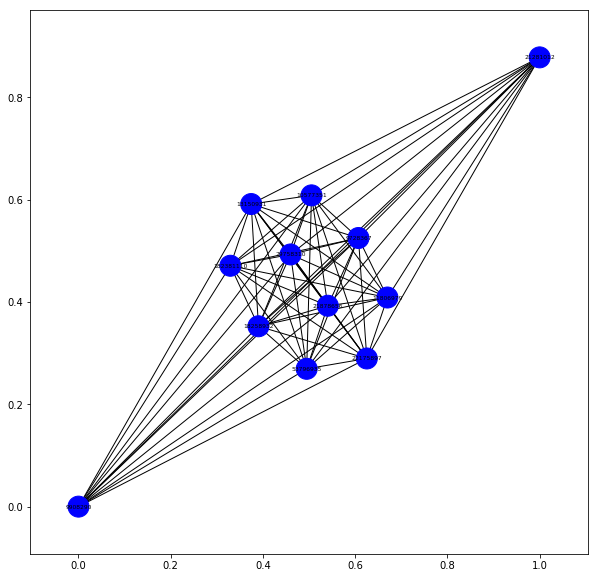

In [206]:
plt.figure(1, figsize=(10,10))
coord = nx.spring_layout(subG)
subG_values = subG.degree().values()
nx.draw_networkx(subG,
                 pos=coord,
                 node_size = [d*40 for d in subG_values],
                 node_color='blue',#katz_color_values,
                 font_size=6
                 )

### Fast unfolding algorithm

In [678]:
tempG = nx.connected_components(friends)
sub_nodes = sorted(list(tempG), key = len,reverse=True)
giantG = friends.subgraph(sub_nodes[0])

In [679]:
nx.write_gml(giantG,'giantG.gml')

In [818]:
#see the slides

### Louvain algorithm

In [680]:
import community
partition = community.best_partition(giantG)
coord = nx.spring_layout(friends)
size = float(len(set(partition.values())))

In [688]:
colors = {0:'red',1:'blue',2:'green',3:'orrange',4:'purple',5:'black'}
list_colors = list(colors.values())

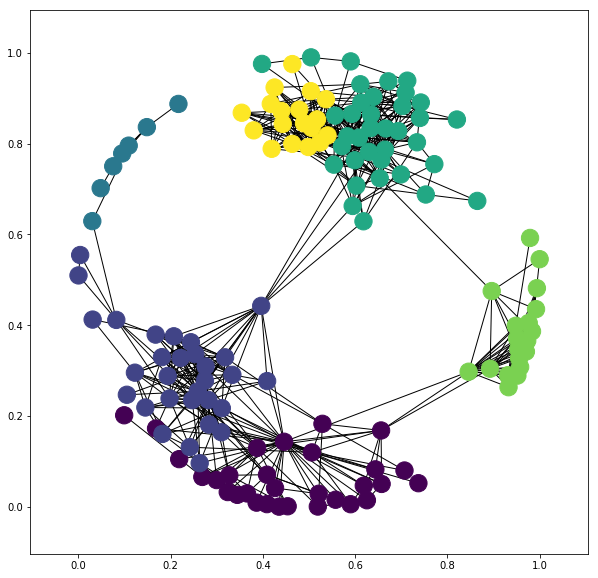

In [689]:
plt.figure(1, figsize=(10,10))
coord = nx.spring_layout(giantG)
nx.draw_networkx(giantG,nodelist=partition.keys(),node_color=[partition[key] for key in partition.keys()],
                 pos=coord,with_labels=False)

### percolation method

In [822]:
clique_comm = nx.k_clique_communities(friends,k=12)

In [823]:
tmp_list = list(clique_comm)

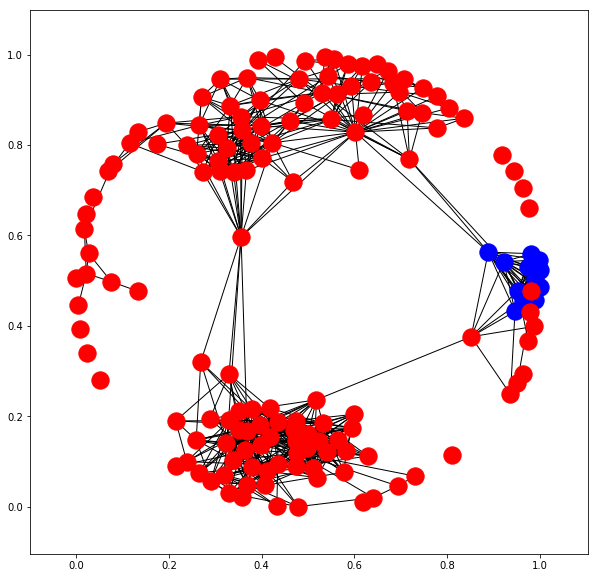

In [824]:
plt.figure(1, figsize=(10,10))
groups = {0:'b',1:'r',2:'g',3:'o',4:'grey',5:'purple',6:'pink',7:'yellow',8:'black'}
coord = nx.spring_layout(friends)
all_nodes = friends.nodes()
count = 0
for cnt in list(tmp_list):
    nx.draw_networkx_nodes(friends,pos=coord,nodelist=cnt,node_color=groups[count])
    nx.draw_networkx_edges(friends,pos=coord)
    count += 1
    for c in cnt:
        all_nodes.remove(c)
# count += 1
    
nx.draw_networkx_nodes(friends, pos=coord, nodelist=all_nodes, node_color=groups[count])